In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band
from helpers.data_transforms import scaled_to_physical_transform
# Try to load LaTeX
latex_flag = False

np.seterr(divide='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 

# pickles contain all the results from the BDT training
pickle_save_dir_prefix = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/pickles/mix_2"
train_samesign = False

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/trigger_12_03/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1001
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"


# Needed for Classical Studies
jet_id = "nojet"
config_id = "CATHODE_8"
project_id = "lowmass"
flow_id = "mix_2"

all_TPR = {}
all_SIC = {}
all_FPR = {}
all_ROC = {}

In [4]:
num_bins_SR = 16 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "cubic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic



In [5]:
SB_left = float(workflow["window_definitions"][particle_id]["SB_left"])
SR_left = float(workflow["window_definitions"][particle_id]["SR_left"])
SR_right = float(workflow["window_definitions"][particle_id]["SR_right"])
SB_right = float(workflow["window_definitions"][particle_id]["SB_right"])

print(SB_left, SB_right)

# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "_SS"
else:
    train_data_id = "_OS"

# train on opp sign means alt test set is samesign
if train_data_id == "_OS": 
    alt_test_data_id = "_SS"
    train_data_id_title = "_OS"
elif train_data_id == "_SS": 
    alt_test_data_id = "_OS"
    train_data_id_title = "_SS"

5.0 16.0


# Load in the original data

In [6]:
# load in the data corresponding to the train id
# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
    test_data_dict = pickle.load(infile)

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


## Load in the BDT results

In [7]:
# if train_samesign = False, this loads in the OS test data
# test 
"""
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}_0_501", "rb") as ifile:
    loc_all_test_data_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_test_data_splits_1 = pickle.load(ifile)
all_test_data_splits = {**loc_all_test_data_splits_0, **loc_all_test_data_splits_1}
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}_0_501", "rb") as ifile:
    loc_all_scores_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_scores_splits_1 = pickle.load(ifile)
all_scores_splits = {**loc_all_scores_splits_0, **loc_all_scores_splits_1}
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}_0_501", "rb") as ifile:
    loc_all_alt_data_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_alt_data_splits_1 = pickle.load(ifile)
all_alt_data_splits = {**loc_all_alt_data_splits_0, **loc_all_alt_data_splits_1}
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)
# alt scores
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}_0_501", "rb") as ifile:
    loc_all_alt_scores_splits_0 = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}_501_1001", "rb") as ifile:
    loc_all_alt_scores_splits_1 = pickle.load(ifile)
all_alt_scores_splits = {**loc_all_alt_scores_splits_0, **loc_all_alt_scores_splits_1}
print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

"""

with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    all_test_data_splits = pickle.load(ifile)


# test scores
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    all_scores_splits = pickle.load(ifile)


# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    all_alt_data_splits = pickle.load(ifile)

# alt scores
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
    all_alt_scores_splits = pickle.load(ifile)

with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    old_scaler = pickle.load(ifile)
    
with open(f"{working_dir}/processed_data/preprocessing_info_{particle_type}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)




## Plot histograms for a small number of FPR thresholds

In [8]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]

num_to_plot = 1

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_to_plot)}

for pseudo_e in range(num_to_plot):
    for i_fold in range(n_folds):
        
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff


In [15]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, num_bins_SR, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)
 
    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses = []

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            #loc_true_masses = mass_scalar(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)
        # consolidate the fold information
        filtered_masses = np.concatenate(filtered_masses)
        
        print(filtered_masses.shape)
        a= filtered_masses[filtered_masses>=7.8]
        a= a[a<=14]
        print(a.shape)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $S/\sqrt{B}$: "+str(round(significance,2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")



    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (0.975, 0.6), fontsize = 16, title = title[:-1])


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    #plt.ylim(0.5, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    


In [16]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]


def plot_features(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, SR_left, SR_right, n_folds= 5, take_score_avg=True):

    n_features = len(feature_set) - 1
    nbins = 40
    bins = {
        "dimu_pt": np.linspace(0, 200, nbins),
        "mu0_ip3d": np.logspace(-4, 0, nbins),
        "mu1_ip3d": np.logspace(-4, 0, nbins),
    }
    labels = {
        "dimu_pt": "$\mu^-\mu^+$ $p_T$ [GeV]",
        "mu0_ip3d": "Hardest $\mu$ 3D IP",
        "mu1_ip3d": "Softer $\mu$ 3D IP",
    }
    
    
    fig, ax = plt.subplots(1, n_features, figsize = (5*n_features, 5))
    
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_features = {i:[] for i in range(n_features)}

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
                
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            
            
            loc_in_SR_indices =  (loc_true_masses >= SR_left) & (loc_true_masses <= SR_right) 
            loc_score_indices = (loc_scores >= score_cutoffs_by_fold[i_fold][threshold])
            
            loc_pass_indices = loc_in_SR_indices.reshape(-1,) & loc_score_indices.reshape(-1,)
            
            for i_feat in range(n_features):
                # undo the scaling
                selected_features = scaled_to_physical_transform(data_dict_by_fold[i_fold][:,i_feat], preprocessing_info[feature_set[i_feat]])
                filtered_features[i_feat].append(selected_features[loc_pass_indices])
                
        for i_feat in range(n_features):
            filtered_features[i_feat] = np.concatenate(filtered_features[i_feat])
            
       

        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"% FPR"


            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
            ax[i_feat].set_yscale("log")
            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            #ax[i_feat].set_ylim(1e-1, 2*1e3)

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])


           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (0.975, 0.4), fontsize = 16, title = legend_title[:-1])

    ax[0].set_ylabel("Events", fontsize = 18)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)
    plt.subplots_adjust(wspace=0)
    
    


In [17]:

"""
fpr_thresholds = [1]
def plot_features(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, SR_left, SR_right, n_folds= 5, take_score_avg=True):

    n_features = len(feature_set) - 1
    nbins = 40
    bins = {
        "dimu_pt": np.linspace(0, 200, nbins),
        "mu0_ip3d": np.logspace(-4, 0, nbins),
        "mu1_ip3d": np.logspace(-4, 0, nbins),
    }
    labels = {
        "dimu_pt": "$\mu^-\mu^+$ $p_T$ [GeV]",
        "mu0_ip3d": "Hardest $\mu$ 3D IP",
        "mu1_ip3d": "Softer $\mu$ 3D IP",
    }
    
    
    
    mmin, mmax = 0.001, 0.004
    
    all_scores_OS = []
    all_pts_OS = []
    
    for t, threshold in enumerate(fpr_thresholds):
        

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
                
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            loc_pts =  scaled_to_physical_transform(data_dict_by_fold[i_fold][:,0], preprocessing_info[feature_set[0]]).reshape(-1,1)
            loc_ip3d0 =  scaled_to_physical_transform(data_dict_by_fold[i_fold][:,1], preprocessing_info[feature_set[1]]).reshape(-1,1)
            loc_ip3d1 =  scaled_to_physical_transform(data_dict_by_fold[i_fold][:,2], preprocessing_info[feature_set[2]]).reshape(-1,1)
            
            
            
            loc_in_SR_indices =  (loc_true_masses.reshape(-1,1) >= SR_left) & (loc_true_masses.reshape(-1,1) <= SR_right)  & (loc_ip3d0 <= mmax)  & (loc_ip3d1 <= mmax)  & (loc_ip3d0 >= mmin)  & (loc_ip3d1 >= mmin)
            print(loc_scores.shape, loc_in_SR_indices.shape)
            all_scores_OS.append(loc_scores.reshape(-1,1)[loc_in_SR_indices])
            all_pts_OS.append(loc_pts[loc_in_SR_indices])
                
     
    all_scores_OS = np.concatenate(all_scores_OS)
    all_pts_OS = np.concatenate(all_pts_OS)
    
    # SAMESIGN
    all_scores_SS = []
    all_pts_SS = []
    
    scores_dict_by_fold = all_alt_scores_splits[0]["ROC_samples"]
    data_dict_by_fold = all_alt_data_splits[0]["ROC_samples"]
    
    for t, threshold in enumerate(fpr_thresholds):
        

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
                
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            loc_pts =  scaled_to_physical_transform(data_dict_by_fold[i_fold][:,0], preprocessing_info[feature_set[0]]).reshape(-1,1)
            loc_ip3d0 =  scaled_to_physical_transform(data_dict_by_fold[i_fold][:,1], preprocessing_info[feature_set[1]]).reshape(-1,1)
            loc_ip3d1 =  scaled_to_physical_transform(data_dict_by_fold[i_fold][:,2], preprocessing_info[feature_set[2]]).reshape(-1,1)
            
            
            loc_in_SR_indices =  (loc_true_masses.reshape(-1,1) >= SR_left) & (loc_true_masses.reshape(-1,1) <= SR_right)  & (loc_ip3d0 <= mmax)  & (loc_ip3d1 <= mmax)  & (loc_ip3d0 >= mmin)  & (loc_ip3d1 >= mmin)
            all_scores_SS.append(loc_scores.reshape(-1,1)[loc_in_SR_indices])
            all_pts_SS.append(loc_pts[loc_in_SR_indices])
                
     
    all_scores_SS = np.concatenate(all_scores_SS)
    all_pts_SS = np.concatenate(all_pts_SS)
    
    
    plt.figure()
    plt.scatter(all_pts_OS, all_scores_OS, s = 1, label = "OS data")
    plt.scatter(all_pts_SS, all_scores_SS, s = 1, label = "OS bkg")
    plt.legend()
    plt.xlabel("dimu_pt")
    plt.ylabel("BDT score")
    plt.xscale("log")
    plt.title(f"ip3d \in {mmin}, {mmax}")
    plt.axvline(25)
    plt.show()
    
    #print(sum(all_pts<25), "events below 25 GeV")
    #print(sum(all_pts>25), "events above 25 GeV")
    
"""

'\nfpr_thresholds = [1]\ndef plot_features(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, SR_left, SR_right, n_folds= 5, take_score_avg=True):\n\n    n_features = len(feature_set) - 1\n    nbins = 40\n    bins = {\n        "dimu_pt": np.linspace(0, 200, nbins),\n        "mu0_ip3d": np.logspace(-4, 0, nbins),\n        "mu1_ip3d": np.logspace(-4, 0, nbins),\n    }\n    labels = {\n        "dimu_pt": "$\\mu^-\\mu^+$ $p_T$ [GeV]",\n        "mu0_ip3d": "Hardest $\\mu$ 3D IP",\n        "mu1_ip3d": "Softer $\\mu$ 3D IP",\n    }\n    \n    \n    \n    mmin, mmax = 0.001, 0.004\n    \n    all_scores_OS = []\n    all_pts_OS = []\n    \n    for t, threshold in enumerate(fpr_thresholds):\n        \n\n        # for each fold, select the events that meet the fpr threshold\n        for i_fold in range(n_folds):\n            if take_score_avg:\n                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)\n            else:\n                lo

(12328, 1)
(5748,)
(3254, 1)
(1606,)
(1374, 1)
(692,)
(734, 1)
(381,)
(173, 1)
(91,)
(97, 1)
(56,)
(19, 1)
(12,)


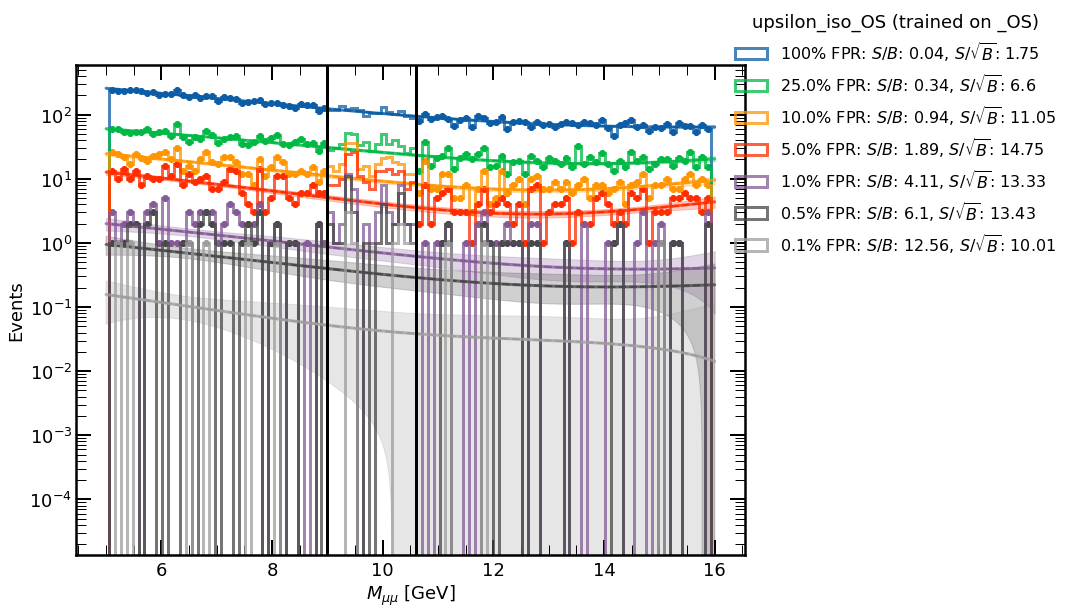

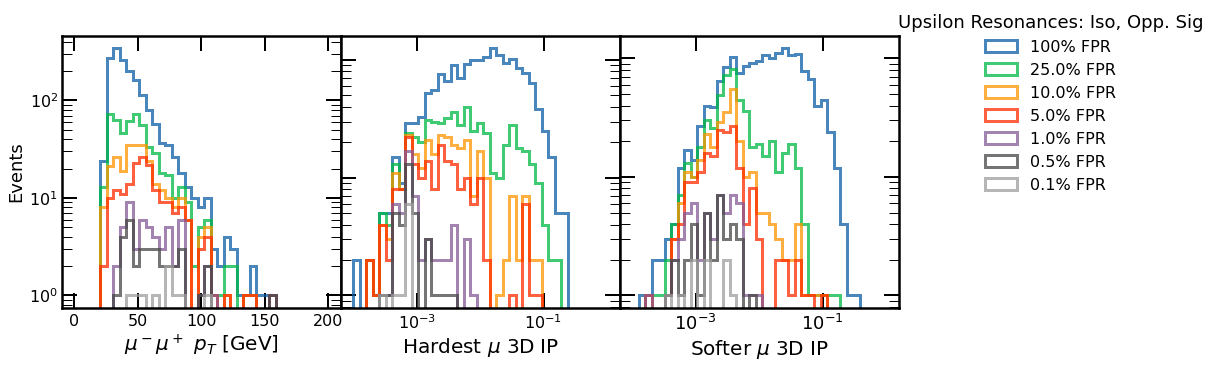

In [18]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""

for i in range(1):
    plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[i], all_scores_splits[i], 
                              score_cutoffs[i], old_scaler, fit_type, num_bins_SR,
                              f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n", 
                              SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


plot_features(fpr_thresholds, all_test_data_splits[0], all_scores_splits[0], score_cutoffs[0], 
              old_scaler, SR_left, SR_right, take_score_avg=False)


(7164, 1)
(3462,)
(1599, 1)
(790,)
(597, 1)
(306,)
(282, 1)
(142,)
(58, 1)
(34,)
(28, 1)
(19,)
(4, 1)
(3,)


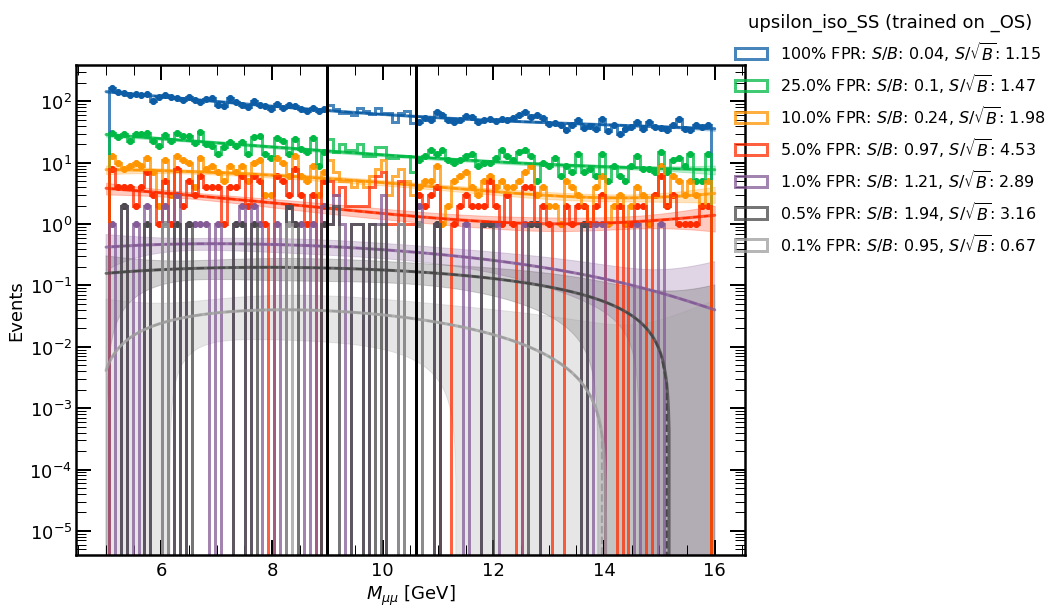

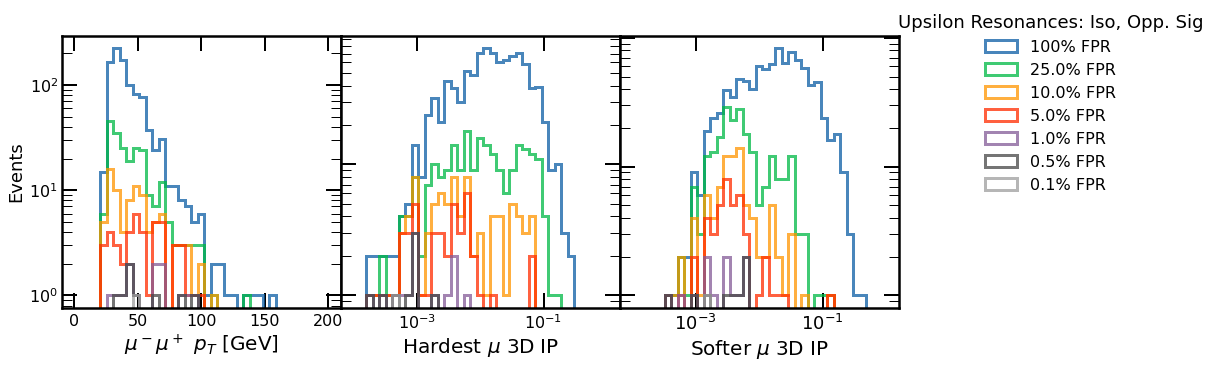

In [19]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], 
                          all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], old_scaler, 
                          fit_type, num_bins_SR,
                          f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n",SB_left, 
                          SR_left, SR_right, SB_right, take_score_avg=False)


plot_features(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], 
              score_cutoffs[pseudo_e_to_plot], old_scaler, SR_left, SR_right, take_score_avg=False)



(61269, 1)
(28377,)
(15108, 1)
(7082,)
(5976, 1)
(2817,)
(3054, 1)
(1434,)
(582, 1)
(247,)
(302, 1)
(120,)
(65, 1)
(27,)


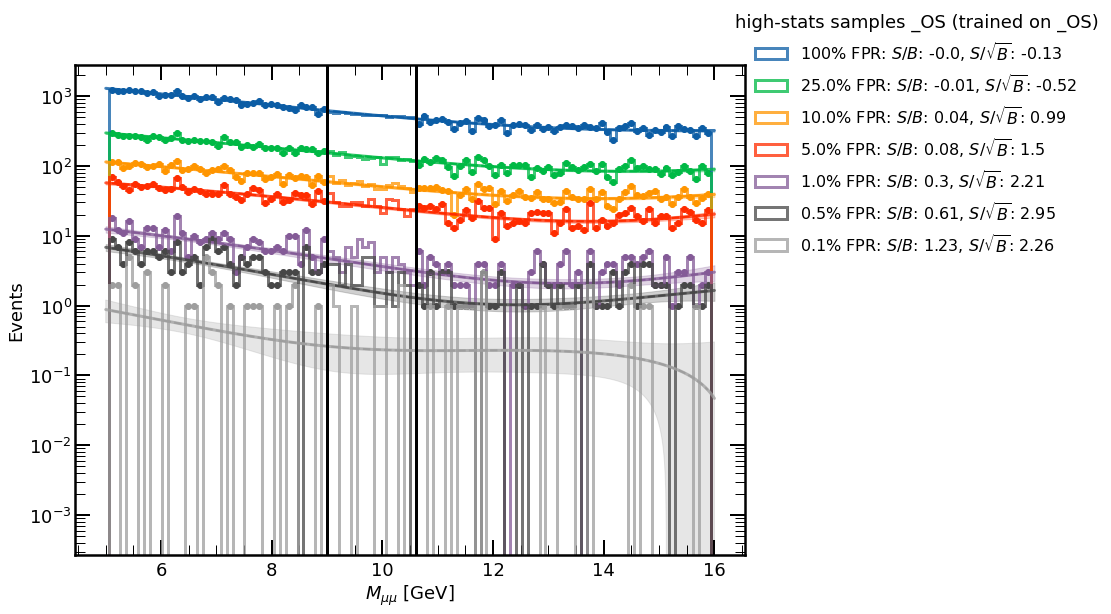

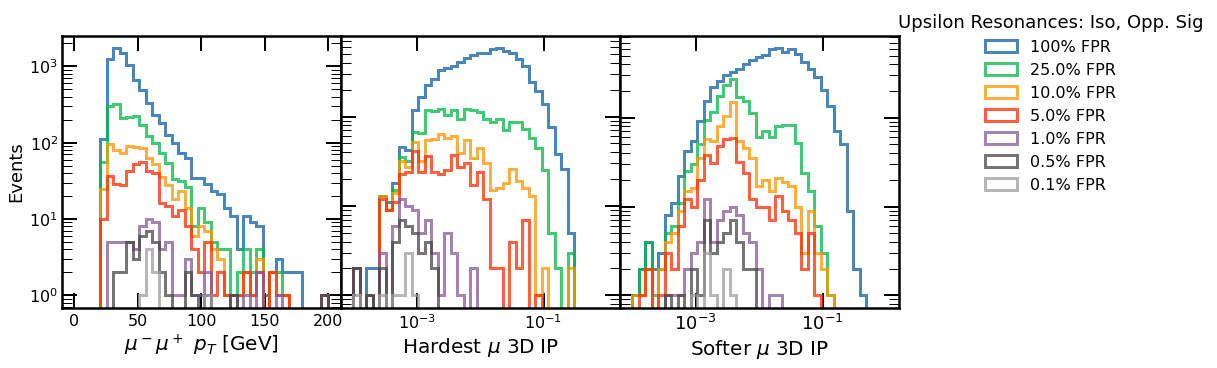

In [20]:
"""
PLOT HISTOGRAM ON FLOW SAMPLES
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], 
                          all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], old_scaler, 
                          fit_type,num_bins_SR,
                          f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
plot_features(fpr_thresholds,  all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"],all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], 
              score_cutoffs[pseudo_e_to_plot], old_scaler, SR_left, SR_right, take_score_avg=False)


# Plot ROC

Calculate the ROC curves for true S / B

In [21]:


# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 50)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff

        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, score_cutoffs):
            
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments))

    for pseudo_e in range(num_pseudoexperiments):

        print(f"On pseudo experiment {pseudo_e}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):

            filtered_masses_bs = []

            for i_fold in range(n_folds):
                loc_true_masses_bs = scaler.inverse_transform(np.array(dataset_by_pseudo_e[pseudo_e][i_fold][:,-1]).reshape(-1,1))
                loc_scores_bs = scores_by_pseudo_e[pseudo_e][i_fold]
                # filter top event based on score cutoff
                loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
                filtered_masses_bs.append(loc_filtered_masses_bs)

            filtered_masses_bs = np.concatenate(filtered_masses_bs)
            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)

            y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
            B_error = np.sqrt(np.sum(y_err**2))
            S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
            
            
            significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

            # TODO: ERRORS
            
            S_yield[t, pseudo_e] = num_S_expected_in_SR
            B_yield[t, pseudo_e] = num_B_expected_in_SR
        
    # calculate summary stats
    TPR = S_yield/S_yield[0,:]
    FPR = B_yield/B_yield[0,:]
    
    

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)
    
    return TPR, FPR, ROC, SIC



KeyError: 1

In [ ]:
TPR, FPR, ROC, SIC = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, score_cutoffs_finegrained)

TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

all_TPR[(fit_type, num_bins_SR)] = TPR_median, TPR_lower, TPR_upper
all_FPR[(fit_type, num_bins_SR)] = FPR_median, FPR_lower, FPR_upper
all_ROC[(fit_type, num_bins_SR)] = ROC_median, ROC_lower, ROC_upper
all_SIC[(fit_type, num_bins_SR)] = SIC_median, SIC_lower, SIC_upper

In [ ]:
colors_dict = {"cubic": "red", "quintic":"blue", "septic":"purple"}
styles_dict = {16:"solid", 12:"dashed", 8:"dotted"}

plt.figure()

for ff, nn in all_TPR.keys():
    plt.plot(all_FPR[(ff,nn)][0], all_TPR[(ff,nn)][0], label=f"{ff}, {nn}", color = colors_dict[ff], linestyle=styles_dict[nn])
    plt.fill_between(all_FPR[(ff,nn)][0], all_TPR[(ff,nn)][1], all_TPR[(ff,nn)][2], alpha = 0.2, color = colors_dict[ff] )
    
plt.plot(all_FPR[(ff,nn)][0], all_FPR[(ff,nn)][0], linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.legend(loc=(1,0))
plt.ylim(-1,6)
plt.ylabel("TPR")
plt.title(f"low-stats data _oppsign (trained on {train_data_id_title})")
plt.show()



In [ ]:

fig, ax = newplot("full", use_tex = latex_flag)
for ff, nn in all_TPR.keys():
    
    ax.plot(all_FPR[(ff,nn)][0], all_SIC[(ff,nn)][0], label=f"{ff}, {nn}", color = colors_dict[ff], linestyle=styles_dict[nn])
    ax.fill_between(all_FPR[(ff,nn)][0], all_SIC[(ff,nn)][1], all_SIC[(ff,nn)][2], alpha = 0.2, color = colors_dict[ff] )
ax.plot(all_FPR[(ff,nn)][0], all_FPR[(ff,nn)][0]/np.sqrt(all_FPR[(ff,nn)][0]), linestyle = "dashed", color = "grey")
plt.legend(loc=(1,0))
ax.set_xscale("log")
ax.set_xlabel("FPR")
ax.set_ylim(-1,30)
ax.set_ylabel("$S/\sqrt{B}$")


Calculate the ROC curves for data vs cathode samples

In [ ]:
from sklearn.metrics import roc_curve

fpr_interp = np.linspace(1e-5, 1, 100)
TPR = np.zeros((fpr_interp.shape[0], num_pseudoexperiments))

for pseudo_e in range(num_pseudoexperiments):

    print(f"On pseudo experiment {pseudo_e}...")
    
    scores_pseudo_e_data = []
    scores_pseudo_e_samples = []

    for i_fold in range(n_folds):
        scores_pseudo_e_data.append(all_scores_splits[pseudo_e][i_fold])
        scores_pseudo_e_samples.append(all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])

    scores_pseudo_e_data = np.concatenate(scores_pseudo_e_data)
    scores_pseudo_e_samples = np.concatenate(scores_pseudo_e_samples)

    scores_all = np.hstack([scores_pseudo_e_data,scores_pseudo_e_samples])
    labels_all = np.hstack([np.ones((scores_pseudo_e_data.shape[0],)),np.zeros((scores_pseudo_e_samples.shape[0],))])
    
    loc_fpr, loc_tpr, _ = roc_curve(labels_all, scores_all)
    tpr_interp = np.interp(fpr_interp, loc_fpr, loc_tpr)
    
    TPR[:,pseudo_e] = tpr_interp

    


In [ ]:
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)

plt.plot(fpr_interp,TPR_median, lw = 0.5)
plt.fill_between(fpr_interp, TPR_lower, TPR_upper, alpha = 0.2)

plt.plot(fpr_interp,fpr_interp, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


    